In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
%matplotlib inline


In [2]:
p2data = pd.read_csv('p2_data.csv', index_col = 0, encoding = "ISO-8859-1") #simplest text encoding
print(p2data.info())
print("\nData has {} unique Diagnosis".format(len(p2data.Diagnosis.unique())))
print("Data has {} unique ItemDescriptions".format(len(p2data.ItemDescription.unique())))
print("Data has {} unique PreventiveFlags:{} \n {}".format(len(p2data.PreventiveFlag.unique()),
                                                           p2data.PreventiveFlag.unique(), 
                                                           p2data.PreventiveFlag.value_counts()))
print("Data has {} null PreventiveFlags\n".format(p2data.PreventiveFlag.isnull().sum()))
p2data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11000 entries, 1 to 11000
Data columns (total 3 columns):
ItemDescription    11000 non-null object
Diagnosis          11000 non-null object
PreventiveFlag     10000 non-null float64
dtypes: float64(1), object(2)
memory usage: 343.8+ KB
None

Data has 2266 unique Diagnosis
Data has 10475 unique ItemDescriptions
Data has 3 unique PreventiveFlags:[ 0.  1. nan] 
 0.0    9322
1.0     678
Name: PreventiveFlag, dtype: int64
Data has 1000 null PreventiveFlags



,ItemDescription,Diagnosis,PreventiveFlag
id,,,
1,Six: Urgent Care Exam - Daytime (8am-6pm),colitis,0.0
2,Jafar: Office Visit/Physical Exam,Stomach Issues,0.0
3,Jafar: Fecal Smears,Stomach Issues,0.0
4,Jafar: metronidazole 50mg,Stomach Issues,0.0
5,Jafar: Fecal analysis for parasites,Stomach Issues,0.0


In [4]:
data = p2data.loc[p2data.PreventiveFlag.notnull()]
# data = data.sample(frac=0.05)

print(data.shape)
data.head()

(10000, 3)


,ItemDescription,Diagnosis,PreventiveFlag
id,,,
1,Six: Urgent Care Exam - Daytime (8am-6pm),colitis,0.0
2,Jafar: Office Visit/Physical Exam,Stomach Issues,0.0
3,Jafar: Fecal Smears,Stomach Issues,0.0
4,Jafar: metronidazole 50mg,Stomach Issues,0.0
5,Jafar: Fecal analysis for parasites,Stomach Issues,0.0


### EDA

In [5]:
from nltk import sent_tokenize, word_tokenize
from time import time
import warnings
warnings.filterwarnings('ignore')

In [6]:
# Is the data balanced? 
label_true = data.PreventiveFlag.value_counts()[1]
label_false = data.PreventiveFlag.value_counts()[0]
print("{} Label 1 vs {} Label 0".format(str(label_true/(label_false+label_true)),
                         str(label_false/(label_false+label_true))))


0.0678 Label 1 vs 0.9322 Label 0


In [ ]:
data['ItemDescription'] = data.ItemDescription.apply(remove_punctuation2)
data['Diagnosis'] = data.Diagnosis.apply(remove_punctuation1)
data.head()

In [ ]:
# Stemming or Lemmatization?
stemmer = PorterStemmer()
data['ItemDescription'] = data.ItemDescription.apply(lambda text: " ".join([stemmer.stem(word) for word in text.split()]))
data['Diagnosis'] = data.Diagnosis.apply(lambda text: " ".join([stemmer.stem(word) for word in text.split()]))

lemmer = WordNetLemmatizer()
# data['ItemDescription'] = data.ItemDescription.apply(lambda text: " ".join([lemmer.lemmatize(word, pos="v") for word in text.split()]))
# data['Diagnosis'] = data.Diagnosis.apply(lambda text: " ".join([lemmer.lemmatize(word, pos="v") for word in text.split()]))
data.head()
# # Remove stopwords in diagnosis... maybe

### Preprocessing

In [7]:
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /Users/iZbra1/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [90]:
# Replace slash with space
# Remove punctuation and extra spaces
# Convert to lower case ?? Not the Item Description, yes for diagnosis
def remove_punctuation1(i_desc):
    pattern = r"[^\w\s]"
    idesc = re.sub(r"/", ' ', i_desc).lower()
    return " ".join(re.sub(pattern, '', idesc).split()) 

# Just word_tokenize: for ItemDescription
# The first word on the IDesc is a proper name. 
def remove_punctuation2(i_desc):
    return " ".join(word_tokenize(i_desc))

def preprocessing(df):
    
    # Remove punctuation
    df['ItemDescription'] = df.ItemDescription.apply(remove_punctuation2)
    df['Diagnosis'] = df.Diagnosis.apply(remove_punctuation1)
    
    # Stemming
    stemmer = PorterStemmer()
    df['ItemDescription'] = df.ItemDescription.apply(lambda text: " ".join([stemmer.stem(word) for word in text.split()]))
    df['Diagnosis'] = df.Diagnosis.apply(lambda text: " ".join([stemmer.stem(word) for word in text.split()]))
    
    return df.ItemDescription.values + " " + df.Diagnosis.values
    
def vectorizer(train, corpus_all, vectorizer_count, vectorizer_tf):
    
    if train:
        vectorizer_count = CountVectorizer(token_pattern='[a-zA-Z]{2,}', stop_words='english')
        one_hot = vectorizer_count.fit_transform(corpus_all)
    else: 
        vectorizer_count._validate_vocabulary()
        one_hot = vectorizer_count.transform(corpus_all)
    
    # TFIDF
    # Term frequency: this summarizes how often a given word appears within a document
    # Inverse document frequency: This downscales words that appear a lot across documents
    # Transforming the matrix based on the learnt frequencies or weights
    # vectorizer_tf.idf_
    
    if train:
        vectorizer_tf = TfidfTransformer()
        freq = vectorizer_tf.fit_transform(one_hot)
    else: 
        freq = vectorizer_tf.transform(one_hot)
    
    return freq.toarray(), vectorizer_count, vectorizer_tf

def get_metrics(df, y, yp, ys=True):
# Evaluation Metrics:

    d_roc = round(roc_auc_score(y, yp),3)
    d_mse = round(mean_squared_error(y, yp),3)
    d_prec = precision_score(y, yp, average=None)
    d_recl = recall_score(y, yp, average=None)
    d_f1 = f1_score(y, yp, average=None)
#     d_report = metrics.classification_report(y, yp, target_names=['class 0', 'class 1'])

    if isinstance(ys, np.ndarray):
        ind_name = 'Training'
        d_acc = round(ys.mean(),3)
    else: 
        #### Validation
        ind_name = "Validation"
        d_acc = round(accuracy_score(y, yp),3)

    return pd.concat([df, pd.DataFrame({'Acc':d_acc, 
                            'Prec_C0':round(d_prec[0],3),
                            'Prec_C1':round(d_prec[1],3),
                            'Recal_C0':round(d_recl[0],3),
                            'Recal_C1':round(d_recl[1],3),
                            'F1_C0':round(d_f1[0],3),
                            'F1_C1':round(d_f1[1],3),
                            'AUC':d_roc, 
                            'MSE':d_mse}, index=[ind_name])])

In [99]:
from sklearn.feature_extraction.text import TfidfVectorizer

test = p2data.loc[p2data.PreventiveFlag.isnull()]
data = p2data.loc[p2data.PreventiveFlag.notnull()]

msk = np.random.rand(len(data)) < 0.8

train = preprocessing(data[msk])
validation = preprocessing(data[~msk])

# Splitting the dataset

# A)  Vectorizer in pipeline
# X_train = train
# y_train = data[msk].PreventiveFlag.values

# X_val = validation
# y_val = data[~msk].PreventiveFlag.values


# B) 

X_train, vc, vt = vectorizer(True, train, False, False)
y_train = data[msk].PreventiveFlag.values

X_val, vc, vt = vectorizer(False, validation, vc, vt)
y_val = data[~msk].PreventiveFlag.values


print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)



(7985, 4905) (7985,) (2015, 4905) (2015,)


### Training and Evaluation: 

In [81]:
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, \
                            mean_squared_error, accuracy_score, f1_score, \
                            precision_score, recall_score
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingClassifier

In [100]:
# Optimal classifiers. 
clf1 = DecisionTreeClassifier(max_depth=2, max_leaf_nodes=42, min_samples_split=2, random_state=42)
clf2 = SGDClassifier(learning_rate='optimal', loss='log', max_iter=4, penalty='l1', random_state=42)
clf3 = LogisticRegression(class_weight='balanced', random_state=42)

clfs = [
    ("DecTree", clf1),
    ("SVMwithSGD", clf2),
    ("LogReg", clf3)
]

# A) 
# mixed_pipe = Pipeline([('v_tfid', TfidfVectorizer()),
#     ("voting", VotingClassifier(clfs, voting="soft"))
# ])


# B) 
mixed_pipe = Pipeline([
    ("voting", VotingClassifier(clfs, voting="soft"))
])

In [101]:
start = time()

mixed_pipe.fit(X_train, y_train)
y_val_pred = mixed_pipe.predict(X_val)

# These predictions can then be used to evaluate the classifier:

y_train_scores = cross_val_score(mixed_pipe, X_train, y_train, cv=10)
y_train_pred = cross_val_predict(mixed_pipe, X_train, y_train, cv=10)

print(time()-start)

73.5184440612793


In [116]:
X_val.shape

(2015, 4905)

In [102]:
res = get_metrics(pd.DataFrame(), y_train, y_train_pred, y_train_scores)
res = get_metrics(res, y_val, y_val_pred, False)
res

,AUC,Acc,F1_C0,F1_C1,MSE,Prec_C0,Prec_C1,Recal_C0,Recal_C1
Training,0.784,0.964,0.981,0.684,0.036,0.97,0.844,0.992,0.575
Validation,0.779,0.963,0.981,0.673,0.037,0.97,0.826,0.991,0.567


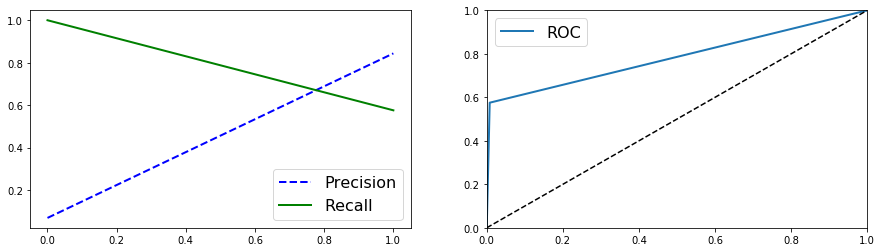

In [103]:
def plot_curves(y_train, y_train_pred):
    # create 2 subplots (horizontally stacked)

    fpr, tpr, thresholds = roc_curve(y_train, y_train_pred)
    precision, recall, f = precision_recall_curve(y_train, y_train_pred)

    fig, axarr = plt.subplots(1,2,figsize=(15,4))

    axarr[0].plot(f, precision[:-1], "b--", label="Precision", linewidth=2)
    axarr[0].plot(f, recall[:-1], "g-", label="Recall", linewidth=2)
    axarr[0].legend(loc="top", fontsize=16)

    # axarr[0].xlabel("Threshold", fontsize=16)
    # axarr[0].ylim([0, 1])

    axarr[1].plot(fpr, tpr, linewidth=2, label='ROC')
    axarr[1].plot([0, 1], [0, 1], 'k--')
    axarr[1].axis([0, 1, 0, 1])
    axarr[1].legend(loc="upper left", fontsize=16)

    plt.show()

plot_curves(y_val, y_val_pred)

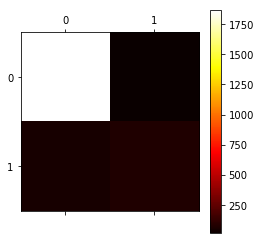

In [106]:
plt.matshow(metrics.confusion_matrix(y_val, y_val_pred), cmap=plt.cm.hot)
plt.colorbar()
plt.show()

# Answer: 
- Dealing with unbalanced dataset: 
    - Even up the training set: train the model with all of the minority class instances and an almost same amount of instances of the majority class. 

In [110]:
X_test, vc, vt = vectorizer(False, preprocessing(test), vc, vt)
y_test = test.PreventiveFlag.values

In [111]:
y_test_pred = mixed_pipe.predict(X_test)